In [3]:
import pandas as pd
import numpy as np
from glob import glob
import json
import os
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [4]:
rows = []
for path in glob("logs/**/*.json"):
    contents = json.loads(open(path).read())
    normalize = {True:'T', False:'F'}[contents.get('normalize', False)]
    M = ('_'+{'microsoft/phi-2':'phi2', 'gpt2': 'gpt2'}[contents['normalizer']]) if normalize == 'T' else ''
    T = {'add': '_ta', 'sub': '_ts', '': ''}[contents.get('normalize_type', '')] if normalize=='T' else ''
    
    dic = {
        "model": path.split("/")[1] + f'_n{normalize}{T}{M}'
    }
    if 'latest' in path:
        continue
    dic['epoch'] = int(re.search(r"epoch\_([0-9]+)", path).groups(1)[0])
    n = 4 if 'sugar' in path else 1
    dic['dataset'] = '_'.join(os.path.basename(path).split("_")[0:n])
    dic.update(contents)
    rows.append(dic)
df = pd.DataFrame(rows)
df.head()

df['model'].unique(), df['dataset'].unique()


model_last_epoch = df.groupby('model').max().epoch.to_dict()
df['last_epoch'] = df.model.apply(lambda m:model_last_epoch[m])

/tmp/ipykernel_21079/2000107698.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  model_last_epoch = df.groupby('model').max().epoch.to_dict()


In [5]:
df

,model,epoch,dataset,acc,normalize,normalizer,normalize_type,acc1,acc5,mean_per_class_recall,last_epoch
0,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,2,sugar_crepe_swap_obj,0.658537,False,microsoft/phi-2,add,NaN,NaN,NaN,5
1,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,2,imagenet1k,NaN,False,microsoft/phi-2,add,0.31272,0.49088,0.31282,5
2,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,2,sugar_crepe_swap_obj,0.695122,True,microsoft/phi-2,add,NaN,NaN,NaN,5
3,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,5,sugar_crepe_swap_obj,0.707317,True,microsoft/phi-2,add,NaN,NaN,NaN,5
4,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,1,sugar_crepe_swap_obj,0.674797,False,microsoft/phi-2,add,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...
1121,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,2,sugar_crepe_swap_att,0.662162,True,microsoft/phi-2,add,NaN,NaN,NaN,4
1122,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,3,sugar_crepe_swap_obj,0.764228,True,microsoft/phi-2,add,NaN,NaN,NaN,4
1123,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,1,sugar_crepe_replace_rel,0.665007,NaN,NaN,NaN,NaN,NaN,NaN,4
1124,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,4,sugar_crepe_replace_rel,0.709104,NaN,NaN,NaN,NaN,NaN,NaN,4


# Leaderboard

In [6]:
df[ (df.dataset=='imagenet1k') & (df.epoch==df.last_epoch)].sort_values(by='acc1', ascending=False)[['model', 'acc1']].round(3)

,model,acc1
719,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.628
476,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.594
904,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.548
218,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.513
648,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.402
816,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.373
345,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.321
949,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nF,0.321
1111,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.318
912,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ts_phi2,0.301


In [7]:
df[ (df.dataset=='sugar_crepe_swap_obj') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc']].round(3)

,model,acc
725,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.780
436,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.772
819,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.768
170,datacomp_dec_ViT-B-16_ep50_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.760
440,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.760
473,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.756
723,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_gpt2,0.748
732,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.744
197,datacomp_dec_ViT-B-16_ep50_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.740
842,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.740


In [8]:
df[ (df.dataset=='sugar_crepe_swap_att') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc']].round(3)

,model,acc
458,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.685
947,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nT_ta_phi2,0.683
1107,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.680
1078,datacomp_dec_ViT-B-16_ep100_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.673
297,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.670
1029,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.670
903,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.670
605,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.670
706,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.662
777,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.661


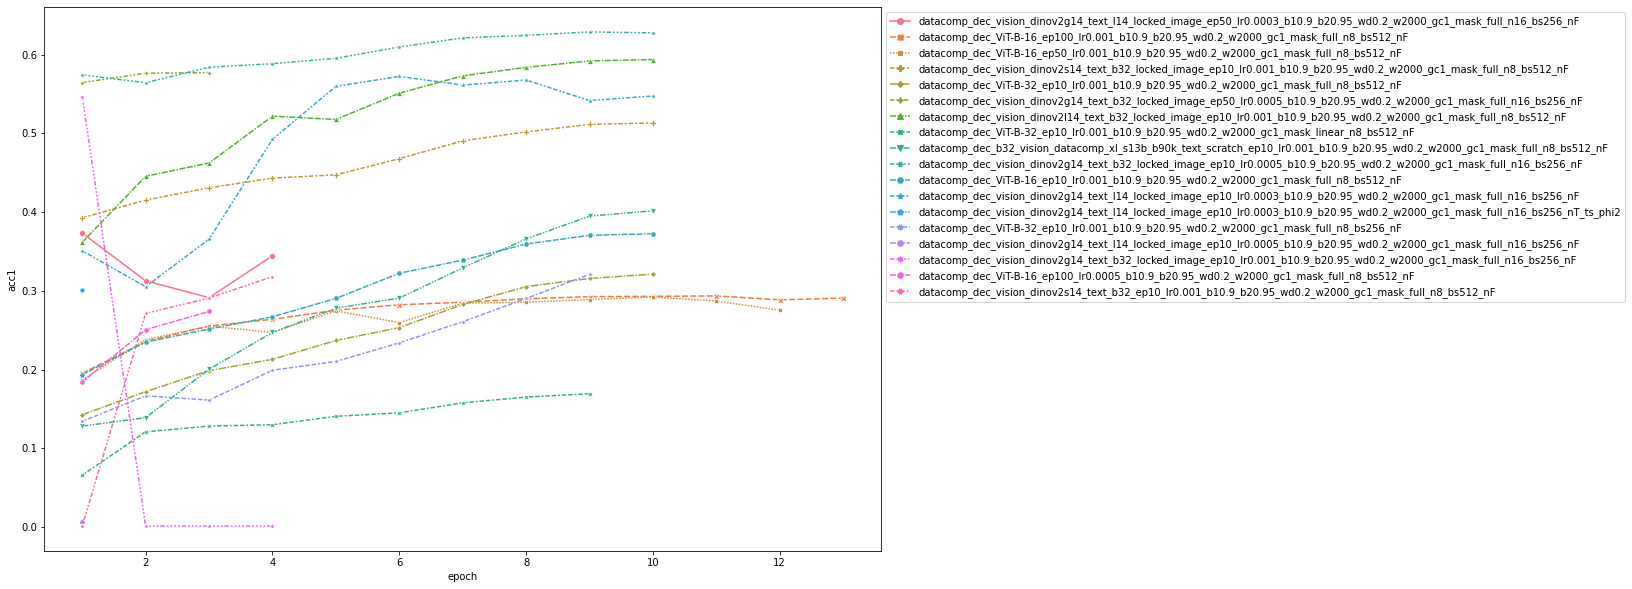

In [9]:
ds = 'imagenet1k'
fig = plt.figure(figsize=(15,10))
sns.lineplot(x='epoch', y='acc1', hue='model', data=df[df.dataset==ds], style='model', markers=True)
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

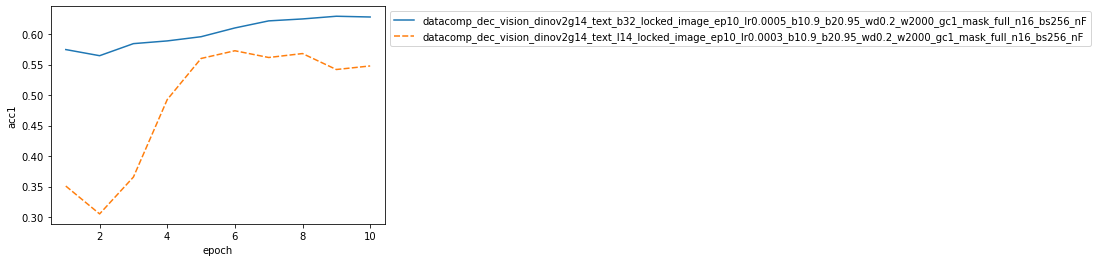

In [10]:
ds = 'imagenet1k'
d = df[df.dataset==ds]
ms = [
'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
]
d = d[d.model.isin(ms)]
sns.lineplot(x='epoch', y='acc1', hue='model', data=d, style='model')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()

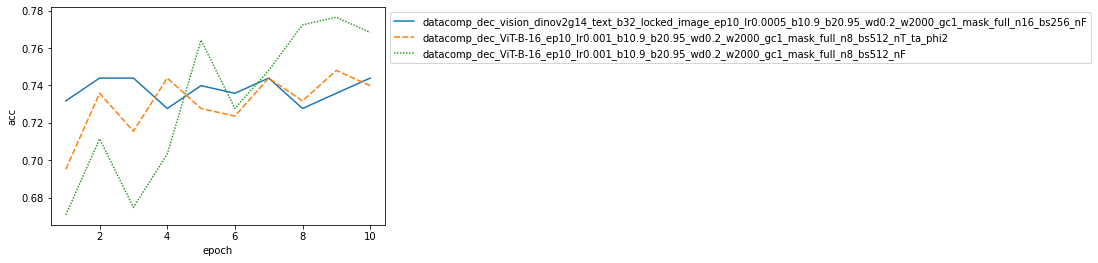

In [11]:
ds = 'sugar_crepe_swap_obj'
d = df[df.dataset==ds]
ms = [
#'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_gpt2',
'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',
#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',

    
'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',

'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',

'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',

#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

]
d = d[d.model.isin(ms)]
sns.lineplot(x='epoch', y='acc', hue='model', data=d, style='model')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()